## Study of type event recognition for the PETALO experiment using ML

### Imports

In [1]:
import numpy  as np
import pandas as pd
import random

from random import randrange, uniform

import matplotlib.pyplot as plt

In [2]:
#in terminal set the course conda env: conda activate machine-learning-course
from tensorflow.keras               import layers
from tensorflow.keras               import regularizers
from tensorflow.keras.utils         import to_categorical
from tensorflow.keras.models        import Sequential
from tensorflow.keras.layers        import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks     import ModelCheckpoint, EarlyStopping

### Loading data:

Code to select events and plotting utils in https://github.com/carmenromo/Analysis/tree/master/machine_learning_course

In [3]:
phot_list, compt_list = [], []
data_file  = '/Users/carmenromoluque/machine-learning-course/full_body_4cmdepth_all_images_new_compton.npz'
data       = np.load(data_file, allow_pickle=True)
for im in data['phot_images']:
    if len(im)==0:
        continue
    phot_list .append(im.reshape(400))
for im in data['compt_images']:
    if len(im)==0:
        continue
    compt_list.append(im.reshape(400))
compt_images = np.array(compt_list)
phot_images  = np.array(phot_list)

In [4]:
phot_images.shape

(19932, 400)

#### Create the noisy events
I am going to use gaussian distributions

In [5]:
def multivariate_gaussian(pos, mu, sigma):
    n         = mu.shape[0]
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    N         = np.sqrt((2*np.pi)**n * sigma_det)
    fac       = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
    return np.exp(-fac/2)/N

In [6]:
#noise_images = 20 *np.random.rand(5000, 400) #20 has been chosen randomly
n_bins  = 20
n_dist  = 10000
gauss2d = []
for i in range(n_dist):
    x_rand = np.linspace(-randrange(1, 10), randrange(1, 10), n_bins)
    y_rand = np.linspace(-randrange(1, 10), randrange(1, 10), n_bins)
    x_rand, y_rand = np.meshgrid(x_rand, y_rand)
    # Mean vector and covariance matrix
    mu = np.array([0., randrange(1, 3)])
    sigma = np.array([[uniform(0.5, 2), -0.5], [-0.5, uniform(0.5, 2)]])
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(x_rand.shape + (2,))
    pos[:, :, 0] = x_rand
    pos[:, :, 1] = y_rand
    # The distribution on the variables X, Y packed into pos.
    gauss2d = np.append(gauss2d, multivariate_gaussian(pos, mu, sigma))

gauss2d      = gauss2d.reshape(n_dist, 400)
noise_images = gauss2d

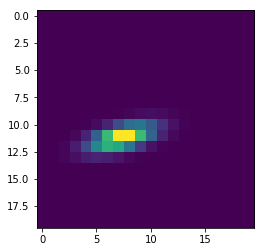

In [7]:
plt.imshow(gauss2d[1].reshape(20, 20));

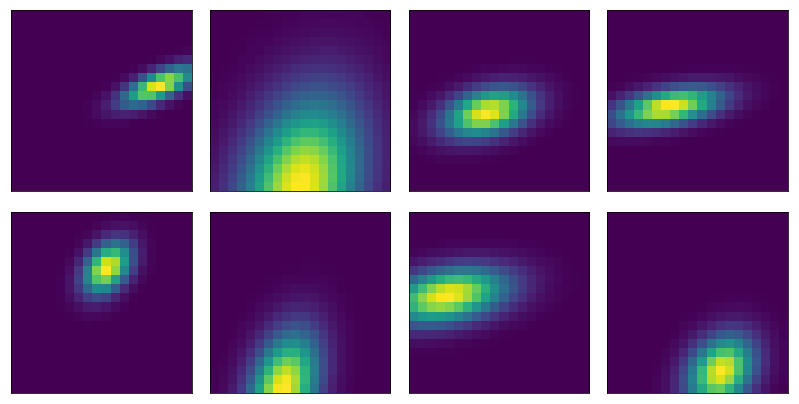

In [8]:
gauss2d_image = gauss2d.reshape(len(gauss2d),20,20)
fig = plt.figure(figsize=(12, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(gauss2d_image[randrange(1, len(gauss2d))], interpolation='nearest')

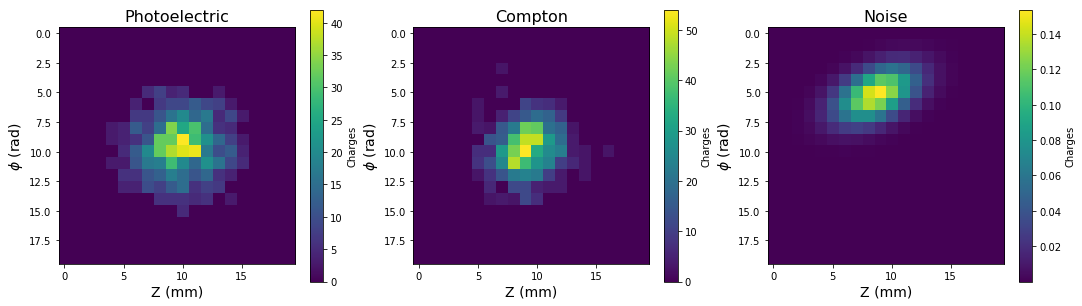

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,5))
fig1 = ax1.imshow( phot_images[4].reshape(20,20))
fig2 = ax2.imshow(compt_images[9].reshape(20,20))
fig3 = ax3.imshow(noise_images[5].reshape(20,20))
ax1.set_xlabel('Z (mm)',       size=14)
ax1.set_ylabel('$\phi$ (rad)', size=14)
ax1.set_title('Photoelectric', size=16)
ax2.set_xlabel('Z (mm)',       size=14)
ax2.set_ylabel('$\phi$ (rad)', size=14)
ax2.set_title('Compton',       size=16)
ax3.set_xlabel('Z (mm)',       size=14)
ax3.set_ylabel('$\phi$ (rad)', size=14)
ax3.set_title('Noise',         size=16)
fig.colorbar(fig1, ax=ax1, label='Charges')
fig.colorbar(fig2, ax=ax2, label='Charges')
fig.colorbar(fig3, ax=ax3, label='Charges')
plt.show()

In the previous plot I have chosen ideal images of photoelectric and compton (phot more compact and compton more sparse), because I found that the pattern in the sipms is pretty similar between these two kinds of events, that's why I would be so happy if the CNN manages to distinguish them successfully.

#### Create the labels:
- compton:       0
- photoelectric: 1
- noise:         2

In [11]:
compt_labels =   np.zeros(len(compt_images))
phot_labels  =   np.ones (len( phot_images))
noise_labels = 2*np.ones (len(noise_images))

### Normalization:

Data can be normalized either using the maximum charge corresponding to every event type or either using the maximum absolute charge value. I think the most correct is the second option because maybe we are missing some information in the number of charges between photoelectric and compton events.

However I find better results in the previous one...

In [12]:
#max_charges = [np.max( phot_images), np.max(compt_images), np.max(noise_images)]
#abs_max = max(max_charges)
#abs_max

#norm_phot_images  =  phot_images/abs_max
#norm_compt_images = compt_images/abs_max
#norm_noise_images = noise_images/abs_max

#norm_phot_images  =  phot_images/np.max( phot_images)
#norm_compt_images = compt_images/np.max(compt_images)
#norm_noise_images = noise_images/np.max(noise_images)

In [13]:
norm_phot_images  = np.array([i/np.max(i) for i in  phot_images])
norm_compt_images = np.array([i/np.max(i) for i in compt_images])
norm_noise_images = np.array([i/np.max(i) for i in noise_images])

## Inputs for the CNN:

In [14]:
y = np.concatenate((compt_labels,      phot_labels,      noise_labels))
x = np.concatenate((norm_compt_images, norm_phot_images, norm_noise_images))
print(y.shape)
print(x.shape)
print(y)

(53996,)
(53996, 400)
[0. 0. 0. ... 2. 2. 2.]


We want to mix the images so that they are not in order (but labels in the same way too):

In [15]:
c = list(zip(x, y))
np.random.shuffle(c)
x, y = zip(*c)
y = np.array(y)
x = np.array(x).astype('float32') 

Split data in trining, validation and testing:

In [16]:
#######
train_split = 40000
#######
test_split  = 5000
#######

y_train = y[                 :train_split]
x_train = x[                 :train_split]
y_val   = y[train_split      :len(y)-test_split]
x_val   = x[train_split      :len(x)-test_split]
y_test  = y[len(y)-test_split:                 ]
x_test  = x[len(x)-test_split:                 ]

In [17]:
print(x_test .shape, y_test .shape)
print(x_train.shape, y_train.shape)
print(x_val  .shape, y_val  .shape)

(5000, 400) (5000,)
(40000, 400) (40000,)
(8996, 400) (8996,)


In [18]:
myset     = set(y_train)
mysettest = set(y_test)
print(myset)
print(mysettest)
print(y)

{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}
[1. 1. 1. ... 0. 0. 0.]


In [19]:
y_train_hot = to_categorical(y_train)
y_val_hot   = to_categorical(y_val)
y_test_hot  = to_categorical(y_test)

print(y_train_hot.shape)
print(y_val_hot  .shape)
print(y_test_hot .shape)

(40000, 3)
(8996, 3)
(5000, 3)


40000 train samples
8996 validation samples


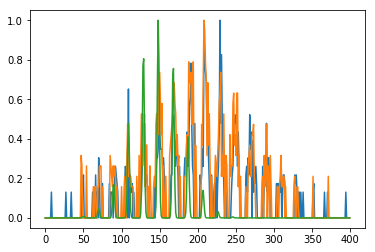

In [20]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
plt.plot(x_train[0])
plt.plot(x_train[1])
plt.plot(x_test[0])
plt.show()

Reshape data for CNN:

In [21]:
x_train_cnn = x_train.reshape(-1, 20, 20, 1)
x_test_cnn  = x_test .reshape(-1, 20, 20, 1)
x_val_cnn   = x_val  .reshape(-1, 20, 20, 1)
x_train_cnn.shape

(40000, 20, 20, 1)

In [22]:
layer = layers.Dense(
    units=64,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)

# a fairly small network for speed
cnnmodel = Sequential()
#cnnmodel.add(Conv2D(128, (4, 4), activation='relu', input_shape=(20, 20, 1)))
cnnmodel.add(Conv2D(64, (3, 3), activation='relu', input_shape=(20, 20, 1))) #2D convolution layer
cnnmodel.add(MaxPooling2D((2, 2))) #Max pooling operation for 2D spatial data.
cnnmodel.add(layer)
cnnmodel.add(Dropout(0.4, input_shape=(20,20,1)))
cnnmodel.add(Conv2D(256, (4, 4), activation='relu'))
#cnnmodel.add(Conv2D(128, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1, input_shape=(20,20,1)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(3, activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='adam', #RMSprop(),
                metrics=['accuracy'])

cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
dense (Dense)                (None, 9, 9, 64)          4160      
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         262400    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 256)         0

In [23]:
batch_size = 50
epochs     = 20

## To prevent it from memorizing the learning samples when the number of epochs is high

dir_path        = '/Users/carmenromoluque/machine-learning-course/'
best_model_name = dir_path + f'CNN_regression_R_{epochs}_{batch_size}.h5'
model_check     = ModelCheckpoint(best_model_name, monitor='val_sigma', verbose=1, save_best_only=True, 
                                  save_weights_only=False, mode='min', save_freq=1)
early_stop      = EarlyStopping(monitor='val_loss', min_delta=0, patience=900, 
                                verbose=1, mode='auto', baseline=None)


history = cnnmodel.fit(x_train_cnn, y_train_hot,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val_cnn, y_val_hot),
                       callbacks=[model_check, early_stop])

Train on 40000 samples, validate on 8996 samples
Epoch 1/20
 2350/40000 [>.............................] - ETA: 1:32 - loss: 0.7817 - accuracy: 0.6243WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4750/40000 [==>...........................] - ETA: 1:17 - loss: 0.6899 - accuracy: 0.6539WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7150/40000 [====>.........................] - ETA: 1:09 - loss: 0.6406 - accuracy: 0.6750WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9550/40000 [======>.......................] - ETA: 1:02 - loss: 0.6120 - accuracy: 0.6888WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11950/40000 [=======>......................] - ETA: 56s - loss: 0.5909 - accuracy: 0.6971WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14350/40000 [=========>....................] - ETA: 51s - loss: 0.5776 - accuracy: 0.7014WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16750/40000 [===========>..................] - ETA: 46s - loss: 0.5656 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19150/40000 [=============>................] - ETA: 41s - loss: 0.5592 - accuracy: 0.7089WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21550/40000 [===============>..............] - ETA: 36s - loss: 0.5526 - accuracy: 0.7117WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23950/40000 [================>.............] - ETA: 31s - loss: 0.5493 - accuracy: 0.7116WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26350/40000 [==================>...........] - ETA: 26s - loss: 0.5449 - accuracy: 0.7139WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28750/40000 [====================>.........] - ETA: 21s - loss: 0.5395 - accuracy: 0.7169WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31150/40000 [======================>.......] - ETA: 17s - loss: 0.5363 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33550/40000 [========================>.....] - ETA: 12s - loss: 0.5336 - accuracy: 0.7195WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36000/40000 [==========================>...] - ETA: 7s - loss: 0.5310 - accuracy: 0.7206WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38450/40000 [===========================>..] - ETA: 2s - loss: 0.5290 - accuracy: 0.7207WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 79s 2ms/sample - loss: 0.5276 - accuracy: 0.7213 - val_loss: 0.4980 - val_accuracy: 0.7303
Epoch 2/20
  850/40000 [..............................] - ETA: 1:13 - loss: 0.4752 - accuracy: 0.7565WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3250/40000 [=>............................] - ETA: 1:09 - loss: 0.4793 - accuracy: 0.7502WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5650/40000 [===>..........................] - ETA: 1:05 - loss: 0.4860 - accuracy: 0.7372WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8050/40000 [=====>........................] - ETA: 1:01 - loss: 0.4872 - accuracy: 0.7359WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10450/40000 [======>.......................] - ETA: 56s - loss: 0.4888 - accuracy: 0.7347WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12850/40000 [========>.....................] - ETA: 51s - loss: 0.4890 - accuracy: 0.7325WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15250/40000 [==========>...................] - ETA: 47s - loss: 0.4879 - accuracy: 0.7334WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17650/40000 [============>.................] - ETA: 42s - loss: 0.4891 - accuracy: 0.7322WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20050/40000 [==============>...............] - ETA: 37s - loss: 0.4878 - accuracy: 0.7336WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22450/40000 [===============>..............] - ETA: 33s - loss: 0.4860 - accuracy: 0.7359WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24850/40000 [=================>............] - ETA: 28s - loss: 0.4864 - accuracy: 0.7349WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27250/40000 [===================>..........] - ETA: 24s - loss: 0.4866 - accuracy: 0.7346WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29650/40000 [=====================>........] - ETA: 19s - loss: 0.4851 - accuracy: 0.7347WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32050/40000 [=======================>......] - ETA: 15s - loss: 0.4847 - accuracy: 0.7350WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34450/40000 [========================>.....] - ETA: 10s - loss: 0.4838 - accuracy: 0.7364WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36900/40000 [==========================>...] - ETA: 5s - loss: 0.4836 - accuracy: 0.7369WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39350/40000 [============================>.] - ETA: 1s - loss: 0.4835 - accuracy: 0.7365WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 76s 2ms/sample - loss: 0.4832 - accuracy: 0.7371 - val_loss: 0.4919 - val_accuracy: 0.7301
Epoch 3/20
 1750/40000 [>.............................] - ETA: 56s - loss: 0.4687 - accuracy: 0.7469WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4150/40000 [==>...........................] - ETA: 52s - loss: 0.4714 - accuracy: 0.7431WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6550/40000 [===>..........................] - ETA: 48s - loss: 0.4759 - accuracy: 0.7394WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8950/40000 [=====>........................] - ETA: 45s - loss: 0.4765 - accuracy: 0.7407WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11350/40000 [=======>......................] - ETA: 41s - loss: 0.4754 - accuracy: 0.7409WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13750/40000 [=========>....................] - ETA: 38s - loss: 0.4761 - accuracy: 0.7432WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16150/40000 [===========>..................] - ETA: 34s - loss: 0.4751 - accuracy: 0.7445WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18550/40000 [============>.................] - ETA: 31s - loss: 0.4736 - accuracy: 0.7446WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20950/40000 [==============>...............] - ETA: 28s - loss: 0.4744 - accuracy: 0.7421WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23350/40000 [================>.............] - ETA: 24s - loss: 0.4731 - accuracy: 0.7437WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25750/40000 [==================>...........] - ETA: 21s - loss: 0.4737 - accuracy: 0.7428WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28150/40000 [====================>.........] - ETA: 18s - loss: 0.4732 - accuracy: 0.7427WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30550/40000 [=====================>........] - ETA: 14s - loss: 0.4740 - accuracy: 0.7419WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32950/40000 [=======================>......] - ETA: 10s - loss: 0.4746 - accuracy: 0.7408WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35400/40000 [=========================>....] - ETA: 7s - loss: 0.4754 - accuracy: 0.7403WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37850/40000 [===========================>..] - ETA: 3s - loss: 0.4753 - accuracy: 0.7403WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 67s 2ms/sample - loss: 0.4760 - accuracy: 0.7390 - val_loss: 0.4804 - val_accuracy: 0.7329
Epoch 4/20
  250/40000 [..............................] - ETA: 1:04 - loss: 0.4475 - accuracy: 0.7720WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2650/40000 [>.............................] - ETA: 1:10 - loss: 0.4911 - accuracy: 0.7215WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5050/40000 [==>...........................] - ETA: 1:02 - loss: 0.4869 - accuracy: 0.7263WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7450/40000 [====>.........................] - ETA: 55s - loss: 0.4801 - accuracy: 0.7349WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9850/40000 [======>.......................] - ETA: 49s - loss: 0.4777 - accuracy: 0.7370WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12250/40000 [========>.....................] - ETA: 44s - loss: 0.4777 - accuracy: 0.7367WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14650/40000 [=========>....................] - ETA: 40s - loss: 0.4750 - accuracy: 0.7386WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17050/40000 [===========>..................] - ETA: 36s - loss: 0.4743 - accuracy: 0.7392WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19450/40000 [=============>................] - ETA: 32s - loss: 0.4719 - accuracy: 0.7404WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21850/40000 [===============>..............] - ETA: 28s - loss: 0.4718 - accuracy: 0.7404WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24250/40000 [=================>............] - ETA: 24s - loss: 0.4715 - accuracy: 0.7397WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26650/40000 [==================>...........] - ETA: 20s - loss: 0.4718 - accuracy: 0.7397WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29050/40000 [====================>.........] - ETA: 16s - loss: 0.4717 - accuracy: 0.7388WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31450/40000 [======================>.......] - ETA: 13s - loss: 0.4721 - accuracy: 0.7385WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33850/40000 [========================>.....] - ETA: 9s - loss: 0.4715 - accuracy: 0.7396WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36300/40000 [==========================>...] - ETA: 5s - loss: 0.4716 - accuracy: 0.7389WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38750/40000 [============================>.] - ETA: 1s - loss: 0.4711 - accuracy: 0.7393WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 64s 2ms/sample - loss: 0.4712 - accuracy: 0.7388 - val_loss: 0.4868 - val_accuracy: 0.7133
Epoch 5/20
 1150/40000 [..............................] - ETA: 58s - loss: 0.4880 - accuracy: 0.7096WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3550/40000 [=>............................] - ETA: 54s - loss: 0.4725 - accuracy: 0.7330WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5950/40000 [===>..........................] - ETA: 50s - loss: 0.4733 - accuracy: 0.7324WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8350/40000 [=====>........................] - ETA: 47s - loss: 0.4696 - accuracy: 0.7347WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10750/40000 [=======>......................] - ETA: 43s - loss: 0.4659 - accuracy: 0.7392WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13150/40000 [========>.....................] - ETA: 39s - loss: 0.4691 - accuracy: 0.7351WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15550/40000 [==========>...................] - ETA: 36s - loss: 0.4686 - accuracy: 0.7363WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17950/40000 [============>.................] - ETA: 32s - loss: 0.4674 - accuracy: 0.7367WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20350/40000 [==============>...............] - ETA: 29s - loss: 0.4672 - accuracy: 0.7374WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22750/40000 [================>.............] - ETA: 25s - loss: 0.4671 - accuracy: 0.7387WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25150/40000 [=================>............] - ETA: 22s - loss: 0.4666 - accuracy: 0.7390WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27550/40000 [===================>..........] - ETA: 18s - loss: 0.4674 - accuracy: 0.7387WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29950/40000 [=====================>........] - ETA: 15s - loss: 0.4670 - accuracy: 0.7394WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32350/40000 [=======================>......] - ETA: 11s - loss: 0.4677 - accuracy: 0.7393WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34800/40000 [=========================>....] - ETA: 7s - loss: 0.4678 - accuracy: 0.7395WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37250/40000 [==========================>...] - ETA: 4s - loss: 0.4673 - accuracy: 0.7397WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39700/40000 [============================>.] - ETA: 0s - loss: 0.4676 - accuracy: 0.7395WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 62s 2ms/sample - loss: 0.4676 - accuracy: 0.7393 - val_loss: 0.4785 - val_accuracy: 0.7261
Epoch 6/20
 2100/40000 [>.............................] - ETA: 56s - loss: 0.4702 - accuracy: 0.7324WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4500/40000 [==>...........................] - ETA: 53s - loss: 0.4657 - accuracy: 0.7407WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6900/40000 [====>.........................] - ETA: 50s - loss: 0.4654 - accuracy: 0.7394WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9300/40000 [=====>........................] - ETA: 46s - loss: 0.4640 - accuracy: 0.7408WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11700/40000 [=======>......................] - ETA: 42s - loss: 0.4643 - accuracy: 0.7411WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14100/40000 [=========>....................] - ETA: 38s - loss: 0.4652 - accuracy: 0.7390WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16500/40000 [===========>..................] - ETA: 35s - loss: 0.4628 - accuracy: 0.7415WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18900/40000 [=============>................] - ETA: 31s - loss: 0.4654 - accuracy: 0.7395WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21300/40000 [==============>...............] - ETA: 28s - loss: 0.4650 - accuracy: 0.7396WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23700/40000 [================>.............] - ETA: 24s - loss: 0.4650 - accuracy: 0.7401WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26100/40000 [==================>...........] - ETA: 20s - loss: 0.4645 - accuracy: 0.7411WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28500/40000 [====================>.........] - ETA: 17s - loss: 0.4637 - accuracy: 0.7420WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30900/40000 [======================>.......] - ETA: 13s - loss: 0.4630 - accuracy: 0.7431WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33300/40000 [=======================>......] - ETA: 10s - loss: 0.4639 - accuracy: 0.7430WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35750/40000 [=========================>....] - ETA: 6s - loss: 0.4640 - accuracy: 0.7430WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38200/40000 [===========================>..] - ETA: 2s - loss: 0.4642 - accuracy: 0.7427WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 62s 2ms/sample - loss: 0.4645 - accuracy: 0.7420 - val_loss: 0.4784 - val_accuracy: 0.7284
Epoch 7/20
  600/40000 [..............................] - ETA: 1:00 - loss: 0.4625 - accuracy: 0.7417WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3000/40000 [=>............................] - ETA: 55s - loss: 0.4599 - accuracy: 0.7387WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5400/40000 [===>..........................] - ETA: 51s - loss: 0.4562 - accuracy: 0.7428WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7800/40000 [====>.........................] - ETA: 50s - loss: 0.4643 - accuracy: 0.7333WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10200/40000 [======>.......................] - ETA: 50s - loss: 0.4652 - accuracy: 0.7318WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12600/40000 [========>.....................] - ETA: 45s - loss: 0.4622 - accuracy: 0.7343WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15000/40000 [==========>...................] - ETA: 41s - loss: 0.4630 - accuracy: 0.7343WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17400/40000 [============>.................] - ETA: 36s - loss: 0.4615 - accuracy: 0.7366WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19800/40000 [=============>................] - ETA: 32s - loss: 0.4618 - accuracy: 0.7371WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22200/40000 [===============>..............] - ETA: 28s - loss: 0.4623 - accuracy: 0.7378WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24600/40000 [=================>............] - ETA: 24s - loss: 0.4620 - accuracy: 0.7391WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27000/40000 [===================>..........] - ETA: 20s - loss: 0.4621 - accuracy: 0.7379WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29400/40000 [=====================>........] - ETA: 16s - loss: 0.4610 - accuracy: 0.7394WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31800/40000 [======================>.......] - ETA: 12s - loss: 0.4606 - accuracy: 0.7405WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34250/40000 [========================>.....] - ETA: 9s - loss: 0.4608 - accuracy: 0.7399WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36700/40000 [==========================>...] - ETA: 5s - loss: 0.4604 - accuracy: 0.7401WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39150/40000 [============================>.] - ETA: 1s - loss: 0.4605 - accuracy: 0.7405WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 65s 2ms/sample - loss: 0.4608 - accuracy: 0.7404 - val_loss: 0.4734 - val_accuracy: 0.7332
Epoch 8/20
 1550/40000 [>.............................] - ETA: 57s - loss: 0.4475 - accuracy: 0.7568WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3950/40000 [=>............................] - ETA: 1:01 - loss: 0.4571 - accuracy: 0.7516WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6350/40000 [===>..........................] - ETA: 54s - loss: 0.4592 - accuracy: 0.7466WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8750/40000 [=====>........................] - ETA: 53s - loss: 0.4552 - accuracy: 0.7480WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11150/40000 [=======>......................] - ETA: 51s - loss: 0.4570 - accuracy: 0.7473WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13550/40000 [=========>....................] - ETA: 48s - loss: 0.4567 - accuracy: 0.7470WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15950/40000 [==========>...................] - ETA: 43s - loss: 0.4564 - accuracy: 0.7478WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18350/40000 [============>.................] - ETA: 38s - loss: 0.4572 - accuracy: 0.7461WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20750/40000 [==============>...............] - ETA: 33s - loss: 0.4580 - accuracy: 0.7454WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23150/40000 [================>.............] - ETA: 28s - loss: 0.4570 - accuracy: 0.7463WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25550/40000 [==================>...........] - ETA: 24s - loss: 0.4565 - accuracy: 0.7473WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27950/40000 [===================>..........] - ETA: 20s - loss: 0.4569 - accuracy: 0.7473WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30350/40000 [=====================>........] - ETA: 16s - loss: 0.4578 - accuracy: 0.7459WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32750/40000 [=======================>......] - ETA: 12s - loss: 0.4592 - accuracy: 0.7451WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35200/40000 [=========================>....] - ETA: 7s - loss: 0.4589 - accuracy: 0.7446WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37650/40000 [===========================>..] - ETA: 3s - loss: 0.4590 - accuracy: 0.7448WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 68s 2ms/sample - loss: 0.4592 - accuracy: 0.7445 - val_loss: 0.4817 - val_accuracy: 0.7279
Epoch 9/20
   50/40000 [..............................] - ETA: 56s - loss: 0.3335 - accuracy: 0.9000WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2450/40000 [>.............................] - ETA: 54s - loss: 0.4557 - accuracy: 0.7453WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4850/40000 [==>...........................] - ETA: 50s - loss: 0.4530 - accuracy: 0.7470WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7250/40000 [====>.........................] - ETA: 47s - loss: 0.4465 - accuracy: 0.7537WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9650/40000 [======>.......................] - ETA: 43s - loss: 0.4517 - accuracy: 0.7476WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12050/40000 [========>.....................] - ETA: 44s - loss: 0.4528 - accuracy: 0.7471WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14450/40000 [=========>....................] - ETA: 43s - loss: 0.4536 - accuracy: 0.7459WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16850/40000 [===========>..................] - ETA: 39s - loss: 0.4541 - accuracy: 0.7462WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19250/40000 [=============>................] - ETA: 35s - loss: 0.4558 - accuracy: 0.7451WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21650/40000 [===============>..............] - ETA: 30s - loss: 0.4551 - accuracy: 0.7460WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24050/40000 [=================>............] - ETA: 26s - loss: 0.4560 - accuracy: 0.7452WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26450/40000 [==================>...........] - ETA: 22s - loss: 0.4550 - accuracy: 0.7463WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28850/40000 [====================>.........] - ETA: 18s - loss: 0.4542 - accuracy: 0.7475WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31250/40000 [======================>.......] - ETA: 14s - loss: 0.4541 - accuracy: 0.7467WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33650/40000 [========================>.....] - ETA: 10s - loss: 0.4540 - accuracy: 0.7461WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36100/40000 [==========================>...] - ETA: 6s - loss: 0.4540 - accuracy: 0.7473WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38550/40000 [===========================>..] - ETA: 2s - loss: 0.4544 - accuracy: 0.7469WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 68s 2ms/sample - loss: 0.4551 - accuracy: 0.7466 - val_loss: 0.4797 - val_accuracy: 0.7249
Epoch 10/20
  950/40000 [..............................] - ETA: 58s - loss: 0.4459 - accuracy: 0.7432WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3350/40000 [=>............................] - ETA: 55s - loss: 0.4350 - accuracy: 0.7546WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5750/40000 [===>..........................] - ETA: 51s - loss: 0.4350 - accuracy: 0.7603WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8150/40000 [=====>........................] - ETA: 48s - loss: 0.4365 - accuracy: 0.7591WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10550/40000 [======>.......................] - ETA: 44s - loss: 0.4433 - accuracy: 0.7533WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12950/40000 [========>.....................] - ETA: 40s - loss: 0.4477 - accuracy: 0.7510WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15350/40000 [==========>...................] - ETA: 36s - loss: 0.4492 - accuracy: 0.7491WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17750/40000 [============>.................] - ETA: 33s - loss: 0.4503 - accuracy: 0.7472WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20150/40000 [==============>...............] - ETA: 30s - loss: 0.4501 - accuracy: 0.7479WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22550/40000 [===============>..............] - ETA: 26s - loss: 0.4507 - accuracy: 0.7477WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24950/40000 [=================>............] - ETA: 22s - loss: 0.4500 - accuracy: 0.7493WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27350/40000 [===================>..........] - ETA: 19s - loss: 0.4495 - accuracy: 0.7502WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29750/40000 [=====================>........] - ETA: 15s - loss: 0.4502 - accuracy: 0.7492WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32150/40000 [=======================>......] - ETA: 11s - loss: 0.4501 - accuracy: 0.7484WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34600/40000 [========================>.....] - ETA: 8s - loss: 0.4508 - accuracy: 0.7479WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37050/40000 [==========================>...] - ETA: 4s - loss: 0.4509 - accuracy: 0.7479WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39500/40000 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.7475WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 62s 2ms/sample - loss: 0.4508 - accuracy: 0.7473 - val_loss: 0.4793 - val_accuracy: 0.7300
Epoch 11/20
 1900/40000 [>.............................] - ETA: 59s - loss: 0.4496 - accuracy: 0.7495 WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4300/40000 [==>...........................] - ETA: 1:02 - loss: 0.4472 - accuracy: 0.7537WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6700/40000 [====>.........................] - ETA: 1:02 - loss: 0.4435 - accuracy: 0.7548WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9100/40000 [=====>........................] - ETA: 58s - loss: 0.4477 - accuracy: 0.7501WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11500/40000 [=======>......................] - ETA: 53s - loss: 0.4453 - accuracy: 0.7541WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13900/40000 [=========>....................] - ETA: 50s - loss: 0.4448 - accuracy: 0.7543WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16300/40000 [===========>..................] - ETA: 44s - loss: 0.4420 - accuracy: 0.7553WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18700/40000 [=============>................] - ETA: 39s - loss: 0.4424 - accuracy: 0.7550WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21100/40000 [==============>...............] - ETA: 34s - loss: 0.4449 - accuracy: 0.7537WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23500/40000 [================>.............] - ETA: 29s - loss: 0.4458 - accuracy: 0.7529WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25900/40000 [==================>...........] - ETA: 24s - loss: 0.4478 - accuracy: 0.7517WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28300/40000 [====================>.........] - ETA: 21s - loss: 0.4465 - accuracy: 0.7526WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30700/40000 [======================>.......] - ETA: 17s - loss: 0.4462 - accuracy: 0.7534WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33100/40000 [=======================>......] - ETA: 12s - loss: 0.4462 - accuracy: 0.7528WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35550/40000 [=========================>....] - ETA: 8s - loss: 0.4468 - accuracy: 0.7519WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38000/40000 [===========================>..] - ETA: 3s - loss: 0.4477 - accuracy: 0.7508WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 76s 2ms/sample - loss: 0.4479 - accuracy: 0.7510 - val_loss: 0.4769 - val_accuracy: 0.7328
Epoch 12/20
  400/40000 [..............................] - ETA: 1:03 - loss: 0.4561 - accuracy: 0.7425WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2800/40000 [=>............................] - ETA: 59s - loss: 0.4527 - accuracy: 0.7579WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5200/40000 [==>...........................] - ETA: 56s - loss: 0.4467 - accuracy: 0.7604WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7600/40000 [====>.........................] - ETA: 54s - loss: 0.4436 - accuracy: 0.7588WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10000/40000 [======>.......................] - ETA: 53s - loss: 0.4428 - accuracy: 0.7593WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12400/40000 [========>.....................] - ETA: 48s - loss: 0.4425 - accuracy: 0.7583WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14800/40000 [==========>...................] - ETA: 43s - loss: 0.4421 - accuracy: 0.7593WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17200/40000 [===========>..................] - ETA: 38s - loss: 0.4426 - accuracy: 0.7570WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19600/40000 [=============>................] - ETA: 34s - loss: 0.4429 - accuracy: 0.7566WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22000/40000 [===============>..............] - ETA: 30s - loss: 0.4435 - accuracy: 0.7566WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24400/40000 [=================>............] - ETA: 26s - loss: 0.4439 - accuracy: 0.7558WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26800/40000 [===================>..........] - ETA: 21s - loss: 0.4439 - accuracy: 0.7551WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29200/40000 [====================>.........] - ETA: 17s - loss: 0.4430 - accuracy: 0.7560WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31600/40000 [======================>.......] - ETA: 13s - loss: 0.4446 - accuracy: 0.7545WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34000/40000 [========================>.....] - ETA: 9s - loss: 0.4446 - accuracy: 0.7549WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36450/40000 [==========================>...] - ETA: 5s - loss: 0.4448 - accuracy: 0.7550WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38900/40000 [============================>.] - ETA: 1s - loss: 0.4442 - accuracy: 0.7556WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 69s 2ms/sample - loss: 0.4443 - accuracy: 0.7558 - val_loss: 0.4827 - val_accuracy: 0.7231
Epoch 13/20
 1300/40000 [..............................] - ETA: 1:06 - loss: 0.4322 - accuracy: 0.7669WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3700/40000 [=>............................] - ETA: 58s - loss: 0.4308 - accuracy: 0.7676WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6100/40000 [===>..........................] - ETA: 56s - loss: 0.4283 - accuracy: 0.7690WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8500/40000 [=====>........................] - ETA: 51s - loss: 0.4347 - accuracy: 0.7612WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10900/40000 [=======>......................] - ETA: 47s - loss: 0.4343 - accuracy: 0.7618WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13300/40000 [========>.....................] - ETA: 43s - loss: 0.4366 - accuracy: 0.7602WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15700/40000 [==========>...................] - ETA: 39s - loss: 0.4355 - accuracy: 0.7597WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18100/40000 [============>.................] - ETA: 35s - loss: 0.4361 - accuracy: 0.7601WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20500/40000 [==============>...............] - ETA: 31s - loss: 0.4387 - accuracy: 0.7575WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22900/40000 [================>.............] - ETA: 28s - loss: 0.4381 - accuracy: 0.7576WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25300/40000 [=================>............] - ETA: 24s - loss: 0.4377 - accuracy: 0.7581WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27700/40000 [===================>..........] - ETA: 20s - loss: 0.4392 - accuracy: 0.7570WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30100/40000 [=====================>........] - ETA: 16s - loss: 0.4403 - accuracy: 0.7556WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32500/40000 [=======================>......] - ETA: 12s - loss: 0.4398 - accuracy: 0.7560WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34950/40000 [=========================>....] - ETA: 8s - loss: 0.4400 - accuracy: 0.7558WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37400/40000 [===========================>..] - ETA: 4s - loss: 0.4400 - accuracy: 0.7561WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39850/40000 [============================>.] - ETA: 0s - loss: 0.4410 - accuracy: 0.7552WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 69s 2ms/sample - loss: 0.4410 - accuracy: 0.7553 - val_loss: 0.4788 - val_accuracy: 0.7235
Epoch 14/20
 2250/40000 [>.............................] - ETA: 1:01 - loss: 0.4401 - accuracy: 0.7676WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4650/40000 [==>...........................] - ETA: 1:00 - loss: 0.4347 - accuracy: 0.7654WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7050/40000 [====>.........................] - ETA: 1:02 - loss: 0.4299 - accuracy: 0.7657WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9450/40000 [======>.......................] - ETA: 57s - loss: 0.4371 - accuracy: 0.7613WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11850/40000 [=======>......................] - ETA: 51s - loss: 0.4371 - accuracy: 0.7611WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14250/40000 [=========>....................] - ETA: 46s - loss: 0.4366 - accuracy: 0.7621WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16650/40000 [===========>..................] - ETA: 42s - loss: 0.4374 - accuracy: 0.7618WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19050/40000 [=============>................] - ETA: 37s - loss: 0.4377 - accuracy: 0.7614WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21450/40000 [===============>..............] - ETA: 33s - loss: 0.4374 - accuracy: 0.7617WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23850/40000 [================>.............] - ETA: 28s - loss: 0.4373 - accuracy: 0.7599WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26250/40000 [==================>...........] - ETA: 24s - loss: 0.4381 - accuracy: 0.7588WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28650/40000 [====================>.........] - ETA: 19s - loss: 0.4381 - accuracy: 0.7582WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31050/40000 [======================>.......] - ETA: 15s - loss: 0.4388 - accuracy: 0.7583WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33450/40000 [========================>.....] - ETA: 11s - loss: 0.4387 - accuracy: 0.7587WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35900/40000 [=========================>....] - ETA: 6s - loss: 0.4377 - accuracy: 0.7593WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38350/40000 [===========================>..] - ETA: 2s - loss: 0.4373 - accuracy: 0.7592WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 70s 2ms/sample - loss: 0.4371 - accuracy: 0.7590 - val_loss: 0.4737 - val_accuracy: 0.7319
Epoch 15/20
  750/40000 [..............................] - ETA: 1:08 - loss: 0.4039 - accuracy: 0.7800WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3150/40000 [=>............................] - ETA: 1:13 - loss: 0.4157 - accuracy: 0.7730WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5550/40000 [===>..........................] - ETA: 1:08 - loss: 0.4119 - accuracy: 0.7764WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7950/40000 [====>.........................] - ETA: 1:00 - loss: 0.4177 - accuracy: 0.7730WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10350/40000 [======>.......................] - ETA: 54s - loss: 0.4225 - accuracy: 0.7692WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12750/40000 [========>.....................] - ETA: 48s - loss: 0.4218 - accuracy: 0.7689WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15150/40000 [==========>...................] - ETA: 43s - loss: 0.4217 - accuracy: 0.7702WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17550/40000 [============>.................] - ETA: 38s - loss: 0.4221 - accuracy: 0.7697WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19950/40000 [=============>................] - ETA: 34s - loss: 0.4242 - accuracy: 0.7688WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22350/40000 [===============>..............] - ETA: 29s - loss: 0.4249 - accuracy: 0.7683WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24750/40000 [=================>............] - ETA: 26s - loss: 0.4261 - accuracy: 0.7673WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27150/40000 [===================>..........] - ETA: 21s - loss: 0.4265 - accuracy: 0.7668WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29550/40000 [=====================>........] - ETA: 17s - loss: 0.4276 - accuracy: 0.7662WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31950/40000 [======================>.......] - ETA: 13s - loss: 0.4295 - accuracy: 0.7641WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34350/40000 [========================>.....] - ETA: 9s - loss: 0.4293 - accuracy: 0.7640WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36800/40000 [==========================>...] - ETA: 5s - loss: 0.4303 - accuracy: 0.7639WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39250/40000 [============================>.] - ETA: 1s - loss: 0.4319 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 70s 2ms/sample - loss: 0.4314 - accuracy: 0.7637 - val_loss: 0.4748 - val_accuracy: 0.7205
Epoch 16/20
 1650/40000 [>.............................] - ETA: 1:23 - loss: 0.4135 - accuracy: 0.7867WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4050/40000 [==>...........................] - ETA: 1:09 - loss: 0.4217 - accuracy: 0.7773WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6450/40000 [===>..........................] - ETA: 59s - loss: 0.4227 - accuracy: 0.7709WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8850/40000 [=====>........................] - ETA: 53s - loss: 0.4231 - accuracy: 0.7727WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11250/40000 [=======>......................] - ETA: 47s - loss: 0.4208 - accuracy: 0.7751WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13650/40000 [=========>....................] - ETA: 42s - loss: 0.4216 - accuracy: 0.7725WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16050/40000 [===========>..................] - ETA: 38s - loss: 0.4199 - accuracy: 0.7739WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18450/40000 [============>.................] - ETA: 34s - loss: 0.4203 - accuracy: 0.7743WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20850/40000 [==============>...............] - ETA: 30s - loss: 0.4210 - accuracy: 0.7733WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23250/40000 [================>.............] - ETA: 26s - loss: 0.4237 - accuracy: 0.7716WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25650/40000 [==================>...........] - ETA: 22s - loss: 0.4239 - accuracy: 0.7713WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28050/40000 [====================>.........] - ETA: 18s - loss: 0.4241 - accuracy: 0.7701WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30450/40000 [=====================>........] - ETA: 14s - loss: 0.4266 - accuracy: 0.7690WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32850/40000 [=======================>......] - ETA: 11s - loss: 0.4278 - accuracy: 0.7685WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35300/40000 [=========================>....] - ETA: 7s - loss: 0.4278 - accuracy: 0.7684WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37750/40000 [===========================>..] - ETA: 3s - loss: 0.4286 - accuracy: 0.7681WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 66s 2ms/sample - loss: 0.4283 - accuracy: 0.7689 - val_loss: 0.4761 - val_accuracy: 0.7279
Epoch 17/20
  150/40000 [..............................] - ETA: 1:17 - loss: 0.4121 - accuracy: 0.8000WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2550/40000 [>.............................] - ETA: 1:14 - loss: 0.4222 - accuracy: 0.7761WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4950/40000 [==>...........................] - ETA: 1:09 - loss: 0.4166 - accuracy: 0.7792WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7350/40000 [====>.........................] - ETA: 1:04 - loss: 0.4193 - accuracy: 0.7747WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9750/40000 [======>.......................] - ETA: 59s - loss: 0.4190 - accuracy: 0.7739WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12150/40000 [========>.....................] - ETA: 54s - loss: 0.4182 - accuracy: 0.7740WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14550/40000 [=========>....................] - ETA: 49s - loss: 0.4184 - accuracy: 0.7729WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16950/40000 [===========>..................] - ETA: 45s - loss: 0.4201 - accuracy: 0.7709WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19350/40000 [=============>................] - ETA: 40s - loss: 0.4220 - accuracy: 0.7702WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21750/40000 [===============>..............] - ETA: 35s - loss: 0.4223 - accuracy: 0.7706WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24150/40000 [=================>............] - ETA: 31s - loss: 0.4220 - accuracy: 0.7712WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26550/40000 [==================>...........] - ETA: 26s - loss: 0.4233 - accuracy: 0.7704WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28950/40000 [====================>.........] - ETA: 21s - loss: 0.4239 - accuracy: 0.7699WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31350/40000 [======================>.......] - ETA: 16s - loss: 0.4227 - accuracy: 0.7715WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33750/40000 [========================>.....] - ETA: 12s - loss: 0.4218 - accuracy: 0.7719WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36200/40000 [==========================>...] - ETA: 7s - loss: 0.4219 - accuracy: 0.7721WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38650/40000 [===========================>..] - ETA: 2s - loss: 0.4239 - accuracy: 0.7707WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 81s 2ms/sample - loss: 0.4239 - accuracy: 0.7708 - val_loss: 0.5217 - val_accuracy: 0.6998
Epoch 18/20
 1050/40000 [..............................] - ETA: 1:16 - loss: 0.4120 - accuracy: 0.7819WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3450/40000 [=>............................] - ETA: 1:12 - loss: 0.4037 - accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5850/40000 [===>..........................] - ETA: 1:07 - loss: 0.4058 - accuracy: 0.7841WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8250/40000 [=====>........................] - ETA: 1:02 - loss: 0.4093 - accuracy: 0.7822WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10650/40000 [======>.......................] - ETA: 57s - loss: 0.4140 - accuracy: 0.7792WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13050/40000 [========>.....................] - ETA: 53s - loss: 0.4136 - accuracy: 0.7793WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15450/40000 [==========>...................] - ETA: 51s - loss: 0.4122 - accuracy: 0.7804WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17850/40000 [============>.................] - ETA: 49s - loss: 0.4126 - accuracy: 0.7796WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20250/40000 [==============>...............] - ETA: 43s - loss: 0.4135 - accuracy: 0.7792WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22650/40000 [===============>..............] - ETA: 38s - loss: 0.4131 - accuracy: 0.7795WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25050/40000 [=================>............] - ETA: 32s - loss: 0.4134 - accuracy: 0.7781WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27450/40000 [===================>..........] - ETA: 26s - loss: 0.4132 - accuracy: 0.7781WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29850/40000 [=====================>........] - ETA: 21s - loss: 0.4131 - accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32250/40000 [=======================>......] - ETA: 16s - loss: 0.4145 - accuracy: 0.7780WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34650/40000 [========================>.....] - ETA: 11s - loss: 0.4152 - accuracy: 0.7771WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37100/40000 [==========================>...] - ETA: 6s - loss: 0.4159 - accuracy: 0.7766WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39550/40000 [============================>.] - ETA: 0s - loss: 0.4166 - accuracy: 0.7762WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 89s 2ms/sample - loss: 0.4169 - accuracy: 0.7762 - val_loss: 0.4872 - val_accuracy: 0.7193
Epoch 19/20
 1950/40000 [>.............................] - ETA: 1:16 - loss: 0.3988 - accuracy: 0.7785WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4350/40000 [==>...........................] - ETA: 1:18 - loss: 0.4024 - accuracy: 0.7821WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6750/40000 [====>.........................] - ETA: 1:14 - loss: 0.4064 - accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9150/40000 [=====>........................] - ETA: 1:06 - loss: 0.4045 - accuracy: 0.7815WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11550/40000 [=======>......................] - ETA: 59s - loss: 0.4054 - accuracy: 0.7820 WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13950/40000 [=========>....................] - ETA: 54s - loss: 0.4064 - accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16350/40000 [===========>..................] - ETA: 48s - loss: 0.4058 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18750/40000 [=============>................] - ETA: 42s - loss: 0.4077 - accuracy: 0.7795WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21150/40000 [==============>...............] - ETA: 37s - loss: 0.4090 - accuracy: 0.7794WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23550/40000 [================>.............] - ETA: 32s - loss: 0.4092 - accuracy: 0.7804WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25950/40000 [==================>...........] - ETA: 27s - loss: 0.4093 - accuracy: 0.7802WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28350/40000 [====================>.........] - ETA: 22s - loss: 0.4080 - accuracy: 0.7811WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30750/40000 [======================>.......] - ETA: 18s - loss: 0.4094 - accuracy: 0.7802WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33150/40000 [=======================>......] - ETA: 13s - loss: 0.4100 - accuracy: 0.7803WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35600/40000 [=========================>....] - ETA: 8s - loss: 0.4097 - accuracy: 0.7808WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38050/40000 [===========================>..] - ETA: 3s - loss: 0.4100 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 81s 2ms/sample - loss: 0.4108 - accuracy: 0.7804 - val_loss: 0.4985 - val_accuracy: 0.7043
Epoch 20/20
  450/40000 [..............................] - ETA: 1:15 - loss: 0.3930 - accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2850/40000 [=>............................] - ETA: 1:10 - loss: 0.3980 - accuracy: 0.7930WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5250/40000 [==>...........................] - ETA: 1:06 - loss: 0.3953 - accuracy: 0.7920WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7650/40000 [====>.........................] - ETA: 1:01 - loss: 0.3964 - accuracy: 0.7915WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10050/40000 [======>.......................] - ETA: 56s - loss: 0.3994 - accuracy: 0.7900WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12450/40000 [========>.....................] - ETA: 51s - loss: 0.4003 - accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14850/40000 [==========>...................] - ETA: 46s - loss: 0.4007 - accuracy: 0.7896WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17250/40000 [===========>..................] - ETA: 42s - loss: 0.4004 - accuracy: 0.7902WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19650/40000 [=============>................] - ETA: 38s - loss: 0.3999 - accuracy: 0.7910WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22050/40000 [===============>..............] - ETA: 33s - loss: 0.4020 - accuracy: 0.7889WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24450/40000 [=================>............] - ETA: 29s - loss: 0.4035 - accuracy: 0.7878WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26850/40000 [===================>..........] - ETA: 24s - loss: 0.4042 - accuracy: 0.7866WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29250/40000 [====================>.........] - ETA: 20s - loss: 0.4046 - accuracy: 0.7857WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31650/40000 [======================>.......] - ETA: 15s - loss: 0.4046 - accuracy: 0.7854WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34050/40000 [========================>.....] - ETA: 11s - loss: 0.4049 - accuracy: 0.7852WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36500/40000 [==========================>...] - ETA: 6s - loss: 0.4056 - accuracy: 0.7847WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38950/40000 [============================>.] - ETA: 1s - loss: 0.4064 - accuracy: 0.7843WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40000/40000 [==============================] - 77s 2ms/sample - loss: 0.4061 - accuracy: 0.7848 - val_loss: 0.4957 - val_accuracy: 0.7115


In [24]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy','val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

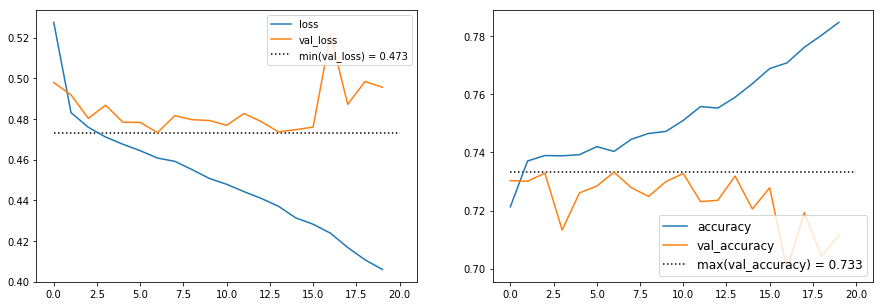

In [25]:
histplot(history)

In [26]:
prediction = []
for i in range(len(x_test_cnn)):
    img = x_test_cnn[i]
    test_image = image.img_to_array(img)
    test_image = np.expand_dims(test_image, axis=0)
    pred = cnnmodel.predict(test_image)
    prediction.append(pred)
prediction = np.array(prediction)

In [27]:
result=[]
for i in range(len(prediction)):
    if np.round(prediction[i]).item(0)==1:
        result.append(0)
    elif np.round(prediction[i]).item(1)==1:
        result.append(1)
    else:
        result.append(2)
result = np.array(result)

result_translate = ['Compt', 'Phot', 'Noise']
result_names = []
for i in range(len(result)):
    result_names.append(result_translate[result[i]])
result_names = np.array(result_names)

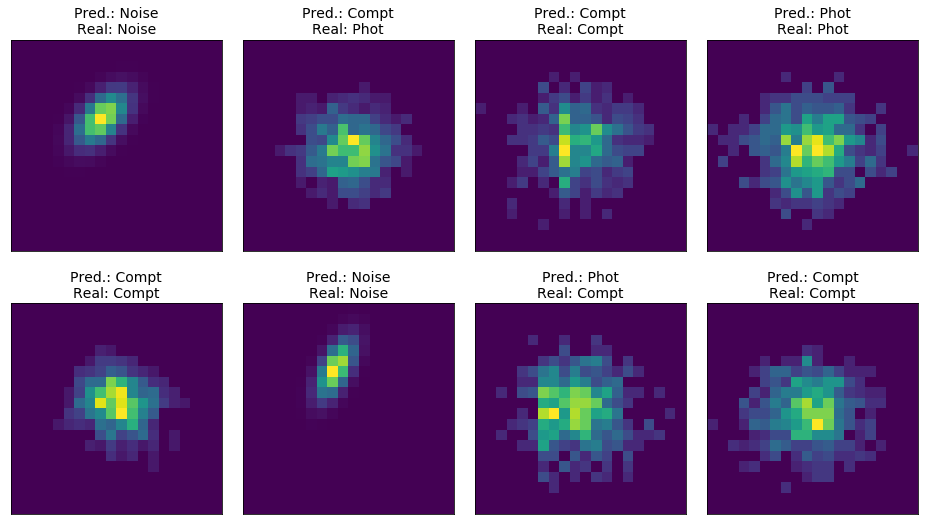

In [28]:
x_test_image = x_test.reshape(len(x_test),20,20)
fig = plt.figure(figsize=(14, 13))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(x_test_image[i], interpolation='nearest')
    
    # label the image with the target value
    ax.set_title(F'Pred.: {result_names[i]}'+ '\n' F'Real: {result_translate[int(y_test[i])]}', fontsize=14)
plt.tick_params()

In [29]:
true_results = np.equal(y_test, result)
percentage   = np.round(sum(true_results)/len(y_test)*100, decimals=2)
print('------------------------------')
print('# CORRECT PREDICTIONS:')
print(f'{sum(true_results)} of total {len(y_test)} ---> {percentage} %')
print('------------------------------')

------------------------------
# CORRECT PREDICTIONS:
3570 of total 5000 ---> 71.4 %
------------------------------


In [30]:
tot_true_phot  = np.sum(y_test==1)/100
tot_true_compt = np.sum(y_test==0)/100
tot_true_noise = np.sum(y_test==2)/100
print('True phot  labeled as  phot --->  ' , int(np.round(np.sum(result[y_test==1]==1)/tot_true_phot)), '%')
print('True phot  labeled as compt --->  ' , int(np.round(np.sum(result[y_test==1]==0)/tot_true_phot)), '%')
print('True phot  labeled as noise --->   ', int(np.round(np.sum(result[y_test==1]==2)/tot_true_phot)), '%')
print('True compt labeled as compt --->  ' , int(np.round(np.sum(result[y_test==0]==0)/tot_true_compt)), '%')
print('True compt labeled as  phot --->  ' , int(np.round(np.sum(result[y_test==0]==1)/tot_true_compt)), '%')
print('True compt labeled as noise --->   ', int(np.round(np.sum(result[y_test==0]==2)/tot_true_compt)), '%')
print('True noise labeled as noise ---> '  , int(np.round(np.sum(result[y_test==2]==2)/tot_true_noise)), '%')
print('True noise labeled as  phot --->   ', int(np.round(np.sum(result[y_test==2]==1)/tot_true_noise)), '%')
print('True noise labeled as compt --->   ', int(np.round(np.sum(result[y_test==2]==0)/tot_true_noise)), '%')

True phot  labeled as  phot --->   60 %
True phot  labeled as compt --->   40 %
True phot  labeled as noise --->    0 %
True compt labeled as compt --->   69 %
True compt labeled as  phot --->   31 %
True compt labeled as noise --->    0 %
True noise labeled as noise --->  100 %
True noise labeled as  phot --->    0 %
True noise labeled as compt --->    0 %
